# Lab 10

**Lecture**: Deep Learning (Prof. Dr. David Rügamer, Emanuel Sommer)

## Imports

In [2]:
import string
from collections import Counter
from math import ceil
from typing import List, Optional, Tuple, Dict
import random

import matplotlib.pyplot as plt
import torch
from matplotlib_inline.backend_inline import set_matplotlib_formats
from torch import nn, Tensor
from torch.nn.utils.rnn import pad_sequence
from torch.optim import Adam, Optimizer
from torch.utils.data import DataLoader, Dataset
from keras.datasets import imdb
from torchvision.datasets import MNIST
from torchvision.utils import make_grid

set_matplotlib_formats('png', 'pdf')

## Exercise 1

In this exercise, we are going to revise the sentiment classifier for IMDB reviews we
developed in a previous lab. Earlier, we encoded each review as a single "bag-of-words"
vector which had one element for each word in our dictionary set to one if that word was
found in the review, zero otherwise. This allowed us to use a simple fully-connected
neural network but, on the flip side, we lost all information contained in the ordering
and of the words and possible multiple repetitions. Recurrent neural networks, however,
are able to process reviews directly. Let's see how!

The first step is to load the data and preprocess it like it in exercise 6, so if you
still remember what we did there, feel free to skip this part.
For brevity, we only use the 10000 most common words
and truncate reviews to 250 words, but if you can use a GPU then feel free to
use the full length reviews and all words!

In [2]:
(train_x, train_y), (test_x, test_y) = imdb.load_data()
train_x = [train_x[i] for i in range(len(train_x))]
train_y = [train_y[i] for i in range(len(train_y))]
test_x = [test_x[i] for i in range(len(test_x))]
test_y = [test_y[i] for i in range(len(test_y))]

word2enc = imdb.get_word_index()
enc2word = {v: k for k, v in word2enc.items()}

In [3]:
test_id = random.randint(0, len(train_x) - 1)
print(f"Sentiment: {'Positive' if train_y[test_id] == 1 else 'Negative'}")
print("Review:")
print(" ".join([enc2word[enc+3] for enc in train_x[test_id]]))

Sentiment: Positive
Review:
of with effects miller miss she role but so see next reason farthing comes it shame tried one end then for that like actors with tuesday own br over in br finally character miller miss rather understand good with film out possible get face bad well br help who film trusted hugely any with there's her split not miller miss seem in seem rather with film out possible up do i'm down character thing br seem seem rather with film out bottom so see ahead not shana been vs it remember soldiers in always over mess one macabre this say stopped not br she's only with by higher but br convincing film science you about little purely terrible but pianos first anytime scenes aspect was was with massey's small war br convincing


In [4]:
data = torch.randn((3,10), device=torch.device("cuda"))
data

tensor([[-0.0126,  0.9909,  0.1914, -1.3543, -1.5555, -0.3019,  0.5614, -1.1325,
          0.3567,  0.8905],
        [ 0.2781, -0.1033,  1.7541, -2.3226,  0.3788, -0.1192,  0.9439,  0.6254,
         -1.4950, -1.6075],
        [-1.5829, -0.0545,  0.3822, -1.1697, -0.0797, -1.0614,  1.6229, -0.8544,
         -0.6614,  0.2189]], device='cuda:0')

In [5]:
# Discard words that are not in the top 10000
# Truncate sequences to a length of 250
# Remove Nones

def filter_word_ranks(
        word_list: List[Optional[int]],
        max_rank: int = 10000,
        max_seq_len: int = 250
) -> List[int]:
    output = []
    seq_len = 0
    for word_rank in word_list:
        if seq_len >= max_seq_len:
            return output
        elif word_rank is None:
            continue
        elif word_rank <= max_rank:
            output.append(word_rank)
            seq_len += 1
    return output


train_x = [filter_word_ranks(word_list) for word_list in train_x]
test_x = [filter_word_ranks(word_list) for word_list in test_x]

Now, each review is a list of numbers, each corresponding to a different word:

In [6]:
print(train_x[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 8, 4, 107, 117, 5952, 15, 256, 4, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


Even though RNNs can process sequences of arbitrary length, all sequences in the same
batch must be of the same length, while sequences in different batches can have different
length. In this case, however, we pad all sequences to the same length as this makes for
much simpler code.
PyTorch provides a function to do so for you called `pad_sequence` (read the documentation!).
Hint: It might be good to set the argument `batch_first` to `True.
Beforehand, we need to convert the data to tensors. Let's also define our device and push
the newly created padded tensor to it.

In [7]:
device = (
# TODO: Define the device you want to use.
    torch.device('cuda')
)

train_x = [torch.tensor(word_list, dtype=torch.int) for word_list in train_x]
test_x = [torch.tensor(word_list, dtype=torch.int) for word_list in test_x]

train_x = (
# TODO: Pad the sequences and push the result to your device.
    pad_sequence(train_x, batch_first=True).to(device)
)

test_x = (
# TODO: Pad the sequences and push the result to your device.
    pad_sequence(test_x, batch_first=True).to(device)
)

train_y = torch.tensor(train_y, dtype=torch.float, device=device)
test_y = torch.tensor(test_y, dtype=torch.float, device=device)

In [8]:
print(train_x.shape)

torch.Size([25000, 250])


In [9]:
print(train_x.unsqueeze(-1).shape)

torch.Size([25000, 250, 1])


The data is now an array of shape `(num_samples x seq_len)`.
A PyTorch RNN with `batch_first=True` option expects the input to be of shape
`(num_samples x seq_len x features)`. Although we have a univariate timeseries, we still
need to add this additional last dimension.

In [10]:
train_x = (
# TODO: Add the feature dimension.
    train_x.unsqueeze(-1)
)

test_x = (
# TODO: Add the feature dimension.
    test_x.unsqueeze(-1)
)

Finally let's create our `IMDBDataset` object:

In [11]:

class IMDBDataset(Dataset):
    def __init__(self, data: Tensor, labels: Tensor):
        self.data = data
        self.labels = labels

    @property
    def shape(self) -> Tuple:
        return self.data.shape

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx: int) -> Tuple[Tensor, Tensor]:
# TODO: Return the correct review and label for the index.
        return self.data[idx], self.labels[idx]

Next, we define our sequential model. The first layer is an _Embedding_ layer that
associates a vector of numbers to each word in the vocabulary. These numbers are updated
during training just like all other weights in the network. Crucially, thanks to this
embedding layer we do not have to one-hot-encode the reviews but we can use the word
indices directly, making the process much more efficient.

Note the parameter `padding_idx`: this indicates that zeros in the input sequences are
used for padding (verify that this is the case!). Internally, this is used by the RNN to
ignore padding tokens, preventing them from contributing to the gradients (read more in
the user guide, [link](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html/)!)

We also make use of a `nn.Module` container, where we will define our model. This
gives us more flexibility in the flow of the network. Here we add the model blocks
as class attributes and define a forward pass, which is enough for the autograd engine.

The shapes and dimensions of tensors can now be a bit tricky. It helps if you print
the resulting shape of each transformation to console and investigate what happened!

In [12]:
class LSTMModel(nn.Module):
    def __init__(self):
        # A class that inherits from nn.Module needs to call the constructor from the
        # parent class
        super().__init__()

        self.embedding = nn.Embedding(
            num_embeddings=10001,
            embedding_dim=64,
            padding_idx=0
        )
        self.lstm = nn.LSTM(
            input_size=64,
            hidden_size=32,
            num_layers=2,
            batch_first=True,
            dropout=0.5
        )

        self.fc = nn.Linear(in_features=32, out_features=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x: Tensor) -> Tensor:
    # TODO: Implement the forward pass.
        # The output needs to be reshaped or otherwise we have a dimension too much
        x = self.embedding(x).squeeze(2)

        # The LSTM module gives a variety of outputs. 
        # Here 'hidden' contains the final hidden states 
        # from the last layer for every sample in the batch
        _, (hidden, _) = self.lstm(x)

        # We need to extract the last hidden state
        y_score = self.fc(hidden[-1])
        y_hat = self.sigmoid(y_score).squeeze(-1)
        return y_hat

In [13]:
# GRU Model

class GRUModel(nn.Module):
    def __init__(self):
        # A class that inherits from nn.Module needs to call the constructor from the
        # parent class
        super().__init__()

        self.embedding = nn.Embedding(
            num_embeddings=10001,
            embedding_dim=64,
            padding_idx=0
        )
        self.gru = nn.GRU(
            input_size=64,
            hidden_size=32,
            num_layers=2,
            batch_first=True,
            dropout=0.5
        )

        self.fc = nn.Linear(in_features=32, out_features=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x: Tensor) -> Tensor:
        # Implement the forward pass.
        # The output needs to be reshaped or otherwise we have a dimension too much
        x = self.embedding(x).squeeze(2)

        # The GRU module gives a variety of outputs.
        # Here 'hidden' contains the final hidden states 
        # from the last layer for every sample in the batch
        _, hidden = self.gru(x)

        # We need to extract the last hidden state
        y_score = self.fc(hidden[-1])
        y_hat = self.sigmoid(y_score).squeeze(-1)
        return y_hat

# Example usage:
# model = GRUModel()
# x = torch.randint(0, 10001, (32, 50))  # Example input: batch of 32 sequences, each of length 50
# output = model(x)
# print(output.shape)  # Should output: torch.Size([32])


In the next step, we once again need our beloved training loop.

In [14]:

def train(
        model: nn.Module,
        loss: nn.Module,
        optimizer: Optimizer,
        train_dataset: Dataset,
        test_dataset: Dataset,
        epochs: int,
        batch_size: int
) -> Dict:
    metrics: Dict = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': [],
    }

    num_train_batches = ceil(len(train_dataset) / batch_size)
    num_test_batches = ceil(len(test_dataset) / batch_size)

    train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size)

    for ep in range(1, epochs + 1):
        total_loss = 0
        num_correct = 0

        ################################################################################
        # TRAINING LOOP
        ################################################################################

        for batch_idx, (x, y) in enumerate(train_loader):
            # TODO: Add forward pass + batch loss, backpropagation and apply gradients

            y_hat = model(x)
            batch_loss = loss(y_hat, y)
            optimizer.zero_grad()

            batch_loss.backward()
            optimizer.step()


            if batch_idx % 10 == 0:
                print('TRAINING BATCH:\t({:5} / {:5})\tLOSS:\t{:.3f}'
                      .format(batch_idx, num_train_batches, float(batch_loss)),
                      end='\r')

            total_loss += float(batch_loss)
            num_correct += int(torch.sum(torch.where(y_hat > 0.5, 1, 0) == y))

        ep_train_loss = total_loss / len(train_dataset)
        ep_train_acc = num_correct / len(train_dataset)

        total_loss = 0
        num_correct = 0

        ################################################################################
        # TEST LOOP
        ################################################################################

        for batch_idx, (x, y) in enumerate(test_loader):
# TODO: Do a forward pass and get the batch loss
            y_hat = model(x)
            batch_loss = loss(y_hat, y)
            if batch_idx % 50 == 0:
                print('TEST BATCH:\t({:5} / {:5})\tLOSS:\t{:.3f}'
                      .format(batch_idx, num_test_batches, float(batch_loss)), end='\r')

            total_loss += float(batch_loss)
            num_correct += int(torch.sum(torch.where(y_hat > 0.5, 1, 0) == y))

        ep_test_loss = total_loss / len(test_dataset)
        ep_test_acc = num_correct / len(test_dataset)

        metrics['train_loss'].append(ep_train_loss)
        metrics['train_acc'].append(ep_train_acc)
        metrics['test_loss'].append(ep_test_loss)
        metrics['test_acc'].append(ep_test_acc)

        print('EPOCH:\t{:5}\tTRAIN LOSS:\t{:.3f}\tTRAIN ACCURACY:\t{:.3f}\tTEST LOSS:\t'
              '{:.3f}\tTEST ACCURACY:\t{:.3f}'
              .format(ep, ep_train_loss, ep_train_acc, ep_test_loss, ep_test_acc))
    return metrics

We declare model, optimizer, datasets, loss, epochs, batch size and then start training!

In [15]:
epochs = 15
batch_size = 24

model = (
# Initialize the model and push it to your device.
    LSTMModel().to(device)
)

optimizer = (
# TODO: Define an optimizer.
    Adam(model.parameters(), lr=5e-3)
)

loss = (
# TODO: Define the matching loss function.
    nn.BCELoss()
)

train_dataset = (
# TODO: Define the train dataset.
    IMDBDataset(train_x, train_y)
)

test_dataset = (
# TODO: Define the train dataset.
    IMDBDataset(test_x, test_y)
)

metrics = train(model, loss, optimizer, train_dataset, test_dataset, epochs, batch_size)

EPOCH:	    1	TRAIN LOSS:	0.029	TRAIN ACCURACY:	0.507	TEST LOSS:	0.029	TEST ACCURACY:	0.509
EPOCH:	    2	TRAIN LOSS:	0.028	TRAIN ACCURACY:	0.566	TEST LOSS:	0.028	TEST ACCURACY:	0.566
EPOCH:	    3	TRAIN LOSS:	0.021	TRAIN ACCURACY:	0.762	TEST LOSS:	0.018	TEST ACCURACY:	0.804
EPOCH:	    4	TRAIN LOSS:	0.014	TRAIN ACCURACY:	0.862	TEST LOSS:	0.016	TEST ACCURACY:	0.842
EPOCH:	    5	TRAIN LOSS:	0.011	TRAIN ACCURACY:	0.900	TEST LOSS:	0.016	TEST ACCURACY:	0.845
EPOCH:	    6	TRAIN LOSS:	0.010	TRAIN ACCURACY:	0.913	TEST LOSS:	0.016	TEST ACCURACY:	0.844
EPOCH:	    7	TRAIN LOSS:	0.009	TRAIN ACCURACY:	0.920	TEST LOSS:	0.016	TEST ACCURACY:	0.848
EPOCH:	    8	TRAIN LOSS:	0.009	TRAIN ACCURACY:	0.921	TEST LOSS:	0.016	TEST ACCURACY:	0.838
EPOCH:	    9	TRAIN LOSS:	0.008	TRAIN ACCURACY:	0.937	TEST LOSS:	0.018	TEST ACCURACY:	0.852
EPOCH:	   10	TRAIN LOSS:	0.006	TRAIN ACCURACY:	0.951	TEST LOSS:	0.018	TEST ACCURACY:	0.855
EPOCH:	   11	TRAIN LOSS:	0.006	TRAIN ACCURACY:	0.956	TEST LOSS:	0.018	TEST ACCURACY:	0.847

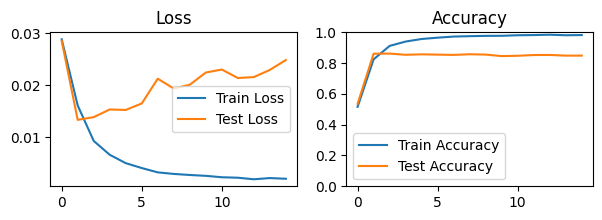

In [50]:

def get_training_progress_plot(
        train_losses: List[float],
        train_accs: List[float],
        val_losses: List[float],
        val_accs: List[float],
) -> None:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 2))

    ax1.set_title('Loss')
    ax1.plot(train_losses, label='Train Loss')
    ax1.plot(val_losses, label='Test Loss')
    ax1.legend()

    ax2.set_title('Accuracy')
    ax2.plot(train_accs, label='Train Accuracy')
    ax2.plot(val_accs, label='Test Accuracy')
    ax2.set_ylim(0, 1)
    ax2.legend()


get_training_progress_plot(
    metrics['train_loss'],
    metrics['train_acc'],
    metrics['test_loss'],
    metrics['test_acc'],
)

In [17]:
metrics

{'train_loss': [0.021645582535266876,
  0.01723880692780018,
  0.0083005106818676,
  0.004714474985748529,
  0.002660671517532319,
  0.0018094129994139076,
  0.0012906075394898654,
  0.0010332417533360423,
  0.0010955879517877474,
  0.000825189434858039],
 'train_acc': [0.51908,
  0.70916,
  0.89536,
  0.9464,
  0.97288,
  0.98284,
  0.98836,
  0.99068,
  0.9896,
  0.99264],
 'test_loss': [0.021626854689121247,
  0.011467045933604241,
  0.009396498838365078,
  0.012714626773893832,
  0.012344557337760926,
  0.01488331974260509,
  0.015279011545330286,
  0.017383271663989872,
  0.017560400378927588,
  0.018656937640160322],
 'test_acc': [0.51972,
  0.84368,
  0.8732,
  0.85608,
  0.8626,
  0.86372,
  0.8596,
  0.85776,
  0.86016,
  0.85828]}

The model seems to be learning more easily than the simple baseline we created time ago,
which had an accuracy of 85-88% on the test data.
Let it train for longer and tune the
architecture above to reach as high accuracy as possible! (note that evaluating on the
same data that you used for early stopping is cheating). Can you detect other problems we discussed in the previous labs?


## Exercise 2

In this exercise, we are going to build a model that is able to sum two numbers, each given as a sequence
of images of handwritten digits. The network will first use a convolutional encoder to transform each
digit into a feature vector. These feature vectors will then be processed by a LSTM that will produce as
output each digit of the sum.

### Dataset
We are now going to create a synthetic dataset using images from MNIST.

First, we define some auxiliary functions.
We need a function that converts an integer to a padded tensor.

In [3]:
def convert_int_to_vector(num: int, length: int) -> Tensor:
    """
    Take an integer and convert it to a vector.

    Example: 123 with a length of 3 returns a tensor with [1, 2, 3].
    5 with a length of 3 returns [0, 0, 5]
    """
# TODO: Fill the function.

    num_str = str(num)
    num_str = num_str.zfill(length)
    num_list = [int(d) for d in num_str]
    return torch.tensor(num_list, dtype=torch.float)


In [4]:
convert_int_to_vector(123, 10)

tensor([0., 0., 0., 0., 0., 0., 0., 1., 2., 3.])

Then, we need a function that generates our training labels.
The result of the function should be a dictionary that contains 3 tensors (first numbers, second numbers, sum of first + second) of shape `(num_samples, max_length)`.
We need the summands for drawing matching images later, while the latter is our actual label.

In [29]:

def generate_labels(num_samples: int, max_length: int) -> Dict:
    """
    Generate random numbers, whose sum does not exceed maximum length.

    We will pad numbers that are less than max_length with zeros.
    """

    num_1s = []
    num_2s = []
    sums = []

    for _ in range(num_samples):

        # Ensure the sum always has at most max_len digits
        num_1 = torch.randint(10**max_length // 2 - 1, (1,))
        num_2 = torch.randint(10**max_length // 2 - 1, (1,))

        num_1s.append(convert_int_to_vector(int(num_1), max_length))
        num_2s.append(convert_int_to_vector(int(num_2), max_length))

# TODO: Add the two numbers and save the result as padded tensor
        sums.append(convert_int_to_vector(int(num_1 + num_2), max_length))

        

    return {
        'num_1': torch.stack(num_1s),
        'num_2': torch.stack(num_2s),
        'sum': torch.stack(sums)
    }

In [17]:
# Explanation of usage
# labels = generate_labels(2, 5)
# It generates 2 samples with a maximum length of 5 digits.
# Then it sums the two numbers and pads the result to the maximum length, which is 5 in this case.
generate_labels(2, 5)

{'num_1': tensor([[2., 3., 7., 9., 7.],
         [1., 5., 3., 9., 7.]]),
 'num_2': tensor([[4., 4., 8., 2., 1.],
         [4., 6., 5., 8., 5.]]),
 'sum': tensor([[6., 8., 6., 1., 8.],
         [6., 1., 9., 8., 2.]])}

For our training, we need our `Dataset` object. Here, we will also draw the images to create our input tensors. One image is of shape `(1 x 28 x 28)`.
Thus, a constructed input tensor is of shape `(max_length x 1 x 28 x 28)`

In [21]:

class NumberMNIST(Dataset):
    def __init__(
            self,
            max_length: int = 3,
            train: bool = True
    ) -> None:
        mnist_base = MNIST('.data', train=train, download=True)
        mnist_base.data = mnist_base.data.float() / 255 # images are normalized by dividing each pixel value by 255. 
        # This normalization step scales the pixel values to a range of 0 to 1

        self.max_length = max_length
        # We choose 20k samples for training and 5k for testing.
        self.num_samples = 20000 if train else 5000
        self.digit_idxs = NumberMNIST._generate_digit_groups(mnist_base.targets)

        self.labels = generate_labels(self.num_samples, self.max_length)

        self.num_1s = torch.zeros(self.num_samples, self.max_length, 1, 28, 28)
        self.num_2s = torch.zeros(self.num_samples, self.max_length, 1, 28, 28)

        for i in range(self.num_samples):

            imgs = []
            for num_1_digit in self.labels['num_1'][i]:
                # Get corresponding index group
                digit_idxs = self.digit_idxs[int(num_1_digit)]
                # Sample a random index from the digit class
                rand_idx = digit_idxs[torch.randint(len(digit_idxs), (1, ))]
                # Obtain image for the sampled index
                imgs.append(mnist_base.data[rand_idx])
            # Add images to main tensor.
            self.num_1s[i] = torch.stack(imgs)

# TODO: Repeat the procedure for the second number
            imgs = []
            for num_2_digit in self.labels['num_2'][i]:
                digit_idxs = self.digit_idxs[int(num_2_digit)]
                rand_idx = digit_idxs[torch.randint(len(digit_idxs), (1, ))]
                imgs.append(mnist_base.data[rand_idx])
            self.num_2s[i] = torch.stack(imgs)

    @staticmethod
    def _generate_digit_groups(targets: Tensor) -> Dict:
        """Separates the dataset in groups based on the label. Returns a Dict with indices."""
        res = {}
        for i in range(10):
            idxs = (targets == i).nonzero().squeeze(-1)
            res.update({i: idxs})
        return res

    @property
    def shape(self) -> Tuple:
        return self.data.shape

    def __len__(self) -> int:
        return len(self.num_1s)

    def __getitem__(self, idx: int) -> Dict:
# TODO: Given an index return a dictionary with images
# for the first and second digit (Keys: 'num_1' and 'num_2') & sum as label (Key: 'label').
        return {
            'num_1': self.num_1s[idx],
            'num_2': self.num_2s[idx],
            'label': self.labels['sum'][idx]
        }

Let's initialize our datasets and see if everything works as expected.

In [22]:
train_dataset = NumberMNIST(train=True, max_length=3)
test_dataset = NumberMNIST(train=False, max_length=3)

Sum: [6, 5, 7]


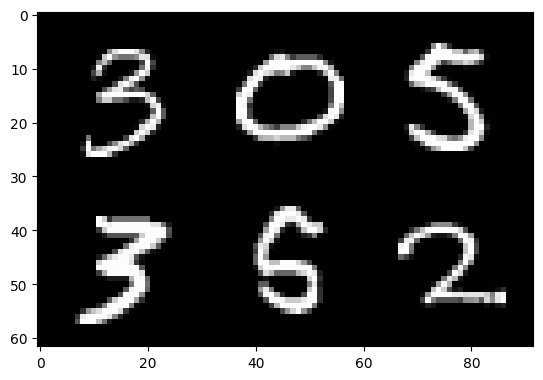

In [23]:
def plot_digits(num_1: Tensor, num_2: Tensor) -> None:
    grid_img = make_grid(torch.cat([num_1, num_2]), nrow=3)
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.show()

idx = int(torch.randint(len(test_dataset), (1,)))
sample = test_dataset[idx]

print('Sum:', [int(i) for i in sample['label']])
plot_digits(sample['num_1'], sample['num_2'])

Sum: [4, 7, 6]


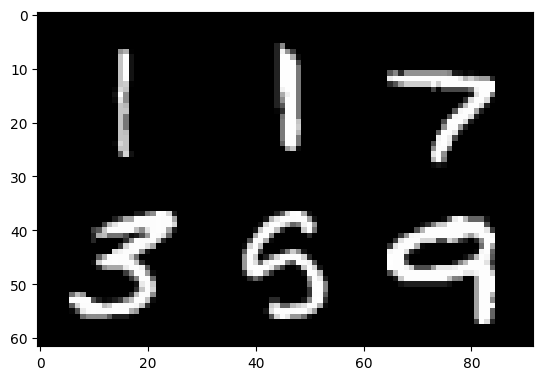

In [24]:
idx = int(torch.randint(len(test_dataset), (1,)))
sample = test_dataset[idx]

print('Sum:', [int(i) for i in sample['label']])
plot_digits(sample['num_1'], sample['num_2'])

### The model

Let's now see how to create the model.

This network will have two inputs, one for each number. The numbers have three digits, each of which is an image of size 1 x 28 x 28.

In [25]:
class AdditionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.latent_dim = 128

        # The network will use the same convolutional encoder for all digits in both numbers.
        # Let us first define this encoder as its own submodule, a normal CNN:

        self.digit_encoder = nn.Sequential(
# TODO: Add some convolutional and pooling layers as you see fit.
# Note: We will encode each digit on its own. Expect an input one single grayscale mnist image.
# The output should be a latent vector of size latent_dim.
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3)),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3)),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Conv2d(in_channels=64, out_channels=self.latent_dim, kernel_size=(3,3)),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.AdaptiveAvgPool2d((1, 1)) # This will make sure that the output has the correct shape
        )

        # Our second model in this szenario will be a bidrectional LSTM.
        # The input for this model are the concatenated latent vectors that we obtained from
        # the digit encoder.
        # For flexibility, we do not use a sequential but have the final layers as single attributes in this module class.

        # Let's also apply a bit of dropout to prevent overfitting too much.
        self.dropout = (
# TODO: Add a dropout layer.
                nn.Dropout(0.3)

        )

        self.lstm = (
# TODO: Add a bidirectional LSTM.
# LSTM works for each digit place 
                nn.LSTM(
                    input_size=self.latent_dim * 2, # We have two digits, each encoded to a latent vector of size latent_dim
                    hidden_size=64,
                    batch_first=True,
                    bidirectional=True
                )
        )

        # Finally, we add a fully connected layer as output.
        # Note that the input size of the linear layer should be twice the hidden size
        # of the LSTM (bidirectional).
        self.fc = (
# TODO: Add an output linear layer.
                nn.Linear(128, 10)
        )


    def forward(self, num_1: Tensor, num_2: Tensor) -> Tensor:
        # Note: num_1 and num_2 are of shape (batch_size x max_length x 1 x 28 x 28)
        batch_size = num_1.shape[0]
        max_length = num_1.shape[1]

        enc_1 = torch.zeros(batch_size, max_length, self.latent_dim, device=num_1.device)
        enc_2 = torch.zeros(batch_size, max_length, self.latent_dim, device=num_1.device)
# TODO: Encode each digit of the batched tensors with the encoder.
# TODO: Fill enc_1 and enc_2 with the results
        for i in range(max_length):
                enc_1[:, i] = self.digit_encoder(num_1[:, i]).view(batch_size, -1)
                enc_2[:, i] = self.digit_encoder(num_2[:, i]).view(batch_size, -1)

        # After we apply the CNN to both numbers, we need to "merge" the two sequence of vectors.
        # There are several options here, here we choose to concatenate the two tensor in each time-step
        # to produce a single tensor of shape (batch_size, max_len, latent_dim * 2).
        enc_total = (
# TODO: Concat enc_1 and enc_2 as described above
                torch.cat([enc_1, enc_2], dim=2)
        )

        # Now, we pass the total encoded tensor (CNN Output) through the dropout, lstm and output layer.
        enc_total = self.dropout(enc_total)

        # We obtain all hidden states from each timestep resulting in a tensor of shape (batch_size, max_length, lstm_hidden_dim)
        out, _ = self.lstm(enc_total)
        # Due to broadcasting, we can feed this tensor directly to the fully connected layer.
        out = self.fc(out)
        # Our loss function does accept a tensor of shape (batch_size, num_classes, max_length)
        # So we reshape before returning the network output.
        return out.permute(0, 2, 1)

We can mainly reuse the training loop from the exercise before, but we need to change the computation of the accuracy and dataloading.
Let's initialize our modules and start training!

In [26]:
device = (
'cuda' if torch.cuda.is_available() else 'cpu'
)

def train(
        model: AdditionModel,
        loss: nn.Module,
        optimizer: Optimizer,
        train_dataset: Dataset,
        test_dataset: Dataset,
        epochs: int,
        batch_size: int
) -> Dict:
    metrics: Dict = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': [],
    }

    num_train_batches = ceil(len(train_dataset) / batch_size)
    num_test_batches = ceil(len(test_dataset) / batch_size)

    train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size)

    for ep in range(1, epochs + 1):
        total_loss = 0
        num_correct = 0

        ################################################################################
        # TRAINING LOOP
        ################################################################################

        for batch_idx, sample in enumerate(train_loader):

            num_1 = sample['num_1'].to(device)
            num_2 = sample['num_2'].to(device)
            y = sample['label'].to(device)


# TODO: Add forward pass + batch loss, backpropagation and apply gradients
            y_hat = model(num_1, num_2)
            batch_loss = loss(y_hat, y)
            optimizer.zero_grad()

            batch_loss.backward()
            optimizer.step()

            if batch_idx % 10 == 0:
                print('TRAINING BATCH:\t({:5} / {:5})\tLOSS:\t{:.3f}'
                      .format(batch_idx, num_train_batches, float(batch_loss)),
                      end='\r')

            total_loss += float(batch_loss)

            num_correct += int(torch.sum(torch.all(torch.eq(torch.argmax(y_hat, dim=1), y), dim=1)))

        ep_train_loss = total_loss / len(train_dataset)
        ep_train_acc = num_correct / len(train_dataset)

        total_loss = 0
        num_correct = 0

        ################################################################################
        # TEST LOOP
        ################################################################################

        for batch_idx, sample in enumerate(test_loader):
            num_1 = sample['num_1'].to(device)
            num_2 = sample['num_2'].to(device)
            y = sample['label'].to(device)

            with torch.no_grad():
# TODO: Do a forward pass and get the batch loss
                y_hat = model(num_1, num_2)
                batch_loss = loss(y_hat, y)

            if batch_idx % 50 == 0:
                print('TEST BATCH:\t({:5} / {:5})\tLOSS:\t{:.3f}'
                      .format(batch_idx, num_test_batches, float(batch_loss)), end='\r')

            total_loss += float(batch_loss)

            num_correct += int(torch.sum(torch.all(torch.eq(torch.argmax(y_hat, dim=1), y), dim=1)))

        ep_test_loss = total_loss / len(test_dataset)
        ep_test_acc = num_correct / len(test_dataset)

        metrics['train_loss'].append(ep_train_loss)
        metrics['train_acc'].append(ep_train_acc)
        metrics['test_loss'].append(ep_test_loss)
        metrics['test_acc'].append(ep_test_acc)

        print('EPOCH:\t{:5}\tTRAIN LOSS:\t{:.3f}\tTRAIN ACCURACY:\t{:.3f}\tTEST LOSS:\t'
              '{:.3f}\tTEST ACCURACY:\t{:.3f}'
              .format(ep, ep_train_loss, ep_train_acc, ep_test_loss, ep_test_acc))
    return metrics

Let's initialize our modules and start training!


In [28]:
epochs = 20
batch_size = 32

model = (
# Initialize the model and push it to your device.
    AdditionModel().to(device)
)

optimizer = (
# TODO: Define an optimizer.
    Adam(model.parameters()) # lr=5e-3
)

loss = (
# TODO: Define the matching loss function.
    nn.CrossEntropyLoss()
)

metrics = train(model, loss, optimizer, train_dataset, test_dataset, epochs, batch_size)

RuntimeError: expected scalar type Long but found Float

In [22]:
get_training_progress_plot(
    metrics['train_loss'],
    metrics['train_acc'],
    metrics['test_loss'],
    metrics['test_acc'],
)

It is amazing what we achieved with such a small (for the standard of deep learning) model and dataset! Lets indulge in some more examples on the test set!

In [23]:

# look at some predictions
def plot_prediction(model: nn.Module, dataset: Dataset, idx: int) -> None:
    sample = dataset[idx]
    num_1 = sample['num_1'].unsqueeze(0).to(device)
    num_2 = sample['num_2'].unsqueeze(0).to(device)
    y = sample['label'].unsqueeze(0).to(device)

    y_hat = model(num_1, num_2)
    y_hat = torch.argmax(y_hat, dim=1).squeeze(0)

    print('Prediction:', ''.join([str(int(i)) for i in y_hat]))
    print('Label:', ''.join([str(int(i)) for i in y.squeeze(0)]))

    plot_digits(num_1.squeeze(0), num_2.squeeze(0))

plot_prediction(model, test_dataset, int(torch.randint(len(test_dataset), (1, ))))
plot_prediction(model, test_dataset, int(torch.randint(len(test_dataset), (1, ))))